# Functional connectivity: distance between subjects

In [1]:
# import necessary libraries
import pickle as pk
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from rich import pretty
from rich.progress import track
from tda import windowing
from tqdm import tqdm

pretty.install()

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/functional_connectivity/"
data_dir = "../data/preprocessing/"
data_out_dir = "../data/functional_connectivity/"
Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(data_out_dir).mkdir(parents=True, exist_ok=True)

# Data

In [3]:
skip = 1  # factor by which the input data is to be downsampled
n_windows = 18  # per condition

# prep_data_df = pd.read_csv(f"{data_dir}EEG_{n_windows}wind_per_condition_skip_{skip}_df.csv")
windowed_data_df = pk.load(
    open(f"{data_dir}EEG_{n_windows}wind_per_condition_skip_{skip}_df.pkl", "rb")
)

In [4]:
#windowed_data_df = pd.DataFrame.from_dict(windowed_data, orient="index")

windowed_data = windowed_data_df.to_dict(orient="index")

In [5]:
windowed_data_df

,file,group,subject,condition,window,series,channels
01_ROE_0,01_ROE_0,high,01,ROE,0,"[[1.0079775810241698e-05, 2.074808597564697e-0...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_1,01_ROE_1,high,01,ROE,1,"[[8.732605934143066e-06, 8.209209442138671e-06...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_2,01_ROE_2,high,01,ROE,2,"[[3.9199738502502436e-06, 3.7186665534973144e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_3,01_ROE_3,high,01,ROE,3,"[[-1.2703986167907715e-05, -1.1578314781188964...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_4,01_ROE_4,high,01,ROE,4,"[[2.1931514739990233e-06, 1.0445833206176757e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
...,...,...,...,...,...,...,...
31_POST_13,31_POST_13,low,31,POST,13,"[[-8.457123637199402e-07, -1.002213716506958e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_14,31_POST_14,low,31,POST,14,"[[7.061112523078918e-07, 1.639171093702316e-07...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_15,31_POST_15,low,31,POST,15,"[[-1.2990448474884034e-06, 4.855538308620453e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_16,31_POST_16,low,31,POST,16,"[[-2.526456117630005e-08, -5.821528434753418e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."


# Correlation matrices

In [10]:
# empty dictionary to store EEG data
corr_dict = dict()
subjects_high = []
subjects_low = []
conditions = []
windows = []

# loop through each file in the list of EEG files
for key in track(windowed_data):
    # print(key)
    # extract information from the dictionary
    subject = windowed_data[key]["subject"]
    # print(subject)
    group = windowed_data[key]["group"]
    # print(group)
    if group == "high" and subject not in subjects_high:
        subjects_high.append(subject)
    elif group == "low" and subject not in subjects_low:
        subjects_low.append(subject)

    condition = windowed_data[key]["condition"]
    if condition not in conditions:
        conditions.append(condition)
    # print(condition)

    window = windowed_data[key]["window"]
    if window not in windows:
        windows.append(window)
    # print(window)

    serie = windowed_data[key]["series"]
    ch = windowed_data[key]["channels"]
    raw_data = pd.DataFrame(serie.T, columns=ch)
    corr = raw_data.corr()
    # print(corr)

    if group not in corr_dict:
        corr_dict[group] = dict()
    if condition not in corr_dict[group]:
        corr_dict[group][condition] = dict()
    if subject not in corr_dict[group][condition]:
        corr_dict[group][condition][subject] = dict()
    if window not in corr_dict[group][condition][subject]:
        corr_dict[group][condition][subject][window] = dict()

    # store correlation data in dictionary
    corr_dict[group][condition][subject][window] = corr

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:02

# Distance between correlation matrices

In [11]:
data = []

# Calcolare le distanze euclidee e riempire la lista data
for group in corr_dict:
    for condition in corr_dict[group]:
        for subject_i in corr_dict[group][condition]:
            for window_i in corr_dict[group][condition][subject_i]:
                corr_i = (
                    corr_dict[group][condition][subject_i][window_i]
                    .to_numpy()
                    .flatten()
                )

                for subject_j in corr_dict[group][condition]:
                    for window_j in corr_dict[group][condition][subject_j]:
                        corr_j = (
                            corr_dict[group][condition][subject_j][window_j]
                            .to_numpy()
                            .flatten()
                        )

                        # Calcola la distanza euclidea
                        distance = np.linalg.norm(corr_i - corr_j)

                        # Aggiungi le informazioni alla lista
                        data.append(
                            [
                                group,
                                condition,
                                subject_i,
                                subject_j,
                                window_i,
                                window_j,
                                distance,
                            ]
                        )

# Creare il dataframe
df = pd.DataFrame(
    data,
    columns=[
        "Group",
        "Condition",
        "Subject_i",
        "Subject_j",
        "Window_i",
        "Window_j",
        "Distance",
    ],
)

In [12]:
df

,Group,Condition,Subject_i,Subject_j,Window_i,Window_j,Distance
0,high,ROE,01,01,0,0,0.000000
1,high,ROE,01,01,0,1,3.956460
2,high,ROE,01,01,0,2,3.705036
3,high,ROE,01,01,0,3,3.700225
4,high,ROE,01,01,0,4,4.403134
...,...,...,...,...,...,...,...
874795,low,POST,31,31,17,13,5.854748
874796,low,POST,31,31,17,14,5.860677
874797,low,POST,31,31,17,15,5.899099
874798,low,POST,31,31,17,16,5.760657


In [15]:
df["Subject_ij"] = df.apply(lambda row: (row['Subject_i'], row['Subject_j']), axis=1)

In [16]:
condition = "ROE"
group = "high"

mask_cond = df["Condition"] == condition
mask_group = df["Group"] == group
mask_same_wdw = df["Window_i"] == df["Window_j"]

mask = mask_same_wdw * mask_cond * mask_group

In [17]:

#mask_subj_ij = (df["Subject_i"] == "01") * (df["Subject_j"] == "01") 

#df[mask].groupby("Subject_ij")["Distance"].mean()

# average over windows
dist_mat = df[mask].groupby("Subject_ij")["Distance"].mean().to_numpy().reshape(15, 15)

In [18]:
dist_mat_dict = dict()

for group in ["high", "low"]:
    
    dist_mat_dict[group] = dict()

    for condition in df.Condition.unique():

        mask_cond = df["Condition"] == condition
        mask_group = df["Group"] == group
        mask_same_wdw = df["Window_i"] == df["Window_j"]

        mask = mask_same_wdw * mask_cond * mask_group

        dist_mat = df[mask].groupby("Subject_ij")["Distance"].mean().to_numpy().reshape(15, 15)

        dist_mat_dict[group][condition] = dist_mat


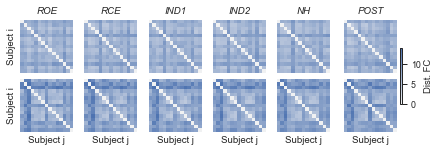

In [19]:
fig, axs = plt.subplots(2, 6, figsize=(6, 2), sharex=True, sharey=True, layout="constrained")

for i, group in enumerate(["high", "low"]):

    for j, condition in enumerate(df.Condition.unique()):
        
        dist_mat = dist_mat_dict[group][condition]
        
        sb.heatmap(dist_mat, ax=axs[i, j],     
                   cmap=cmap,
                    square=True,
                    cbar=False,
                    #xticklabels=conditions_list,
                    #yticklabels=conditions_list,
                    cbar_kws={"shrink": 0.6},
                    vmin=0,
                    vmax=14)
        
for i, ax in enumerate(axs[0, :]):
    ax.set_title(df.Condition.unique()[i], style="italic")
    
for i, ax in enumerate(axs[1, :]):
    ax.set_xlabel("Subject j")
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, ax in enumerate(axs[:, 0]):
    ax.set_ylabel("Subject i")
    
fig.colorbar(axs[-1, -1].get_children()[0], ax=axs[:, -1], shrink=0.5, label="Dist. FC")#, ticks=[0, 0.5, 1])


fig_name = f"distance_matrices_between_subjects_{n_windows}_windows"
#plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")


In [20]:
n_cond = 6
n_subj = 15

dist_mat_avg_dict = dict()

for i, group in enumerate(["high", "low"]):
    
    dist_mat = np.zeros((n_subj, n_subj))

    for j, condition in enumerate(df.Condition.unique()):
        
        dist_mat += dist_mat_dict[group][condition]
        
    dist_mat /= n_cond
    
    dist_mat_avg_dict[group] = dist_mat

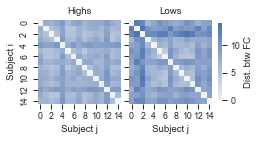

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2), sharex=False, sharey=True, layout="constrained")

ax1, ax2 = axs

im1 = sb.heatmap(
    dist_mat_avg_dict["high"],
    cmap=cmap,
    square=True,
    cbar=False,
    ax=ax1,
    #xticklabels=conditions_list,
    #yticklabels=conditions_list,
    cbar_kws={"shrink": 0.6},
    vmin=0,
    vmax=14
)

ax1.set_xlabel("Subject j")
ax1.set_ylabel("Subject i")

#########


ax2 = sb.heatmap(
    dist_mat_avg_dict["low"],
    cmap=cmap,
    square=True,
    cbar=True,
    ax=ax2,
    #xticklabels=conditions_list,
    #yticklabels=conditions_list,
    cbar_kws={"shrink": 0.6, "label":"Dist. btw FC"},
    vmin=0,
    vmax=14
)

ax2.set_xlabel("Subject j")
#ax2.set_xticklabels(conditions_list, rotation=90, ha="center")
#ax2.set_yticklabels(conditions_list, rotation=0, va="center")

#fig.colorbar(
#    ax1.collections[0], ax=axs, shrink=0.5, fraction=0.25, label="FC corr. dist."
#)

ax1.set_title("Highs")
ax2.set_title("Lows")

title = "FC_DM_both"
# plt.suptitle(title)


fig_name = f"distance_matrices_between_subjects_avg_{n_windows}_windows"
#plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

plt.show()

In [22]:
df[mask]

,Group,Condition,Subject_i,Subject_j,Window_i,Window_j,Distance,Subject_ij
801900,low,POST,17,17,0,0,0.000000,"(17, 17)"
801918,low,POST,17,18,0,0,11.945315,"(17, 18)"
801936,low,POST,17,19,0,0,8.322320,"(17, 19)"
801954,low,POST,17,20,0,0,5.676690,"(17, 20)"
801972,low,POST,17,21,0,0,6.553434,"(17, 21)"
...,...,...,...,...,...,...,...,...
874727,low,POST,31,27,17,17,9.966125,"(31, 27)"
874745,low,POST,31,28,17,17,10.258021,"(31, 28)"
874763,low,POST,31,29,17,17,9.096250,"(31, 29)"
874781,low,POST,31,30,17,17,8.731976,"(31, 30)"


In [23]:
#mask_cond = df["Condition"] == condition
#mask_group = df["Group"] == group
mask_same_wdw = df["Window_i"] == df["Window_j"]

mask = mask_same_wdw 

df[mask]

,Group,Condition,Subject_i,Subject_j,Window_i,Window_j,Distance,Subject_ij
0,high,ROE,01,01,0,0,0.000000,"(01, 01)"
18,high,ROE,01,02,0,0,7.301901,"(01, 02)"
36,high,ROE,01,03,0,0,8.214360,"(01, 03)"
54,high,ROE,01,04,0,0,7.145456,"(01, 04)"
72,high,ROE,01,05,0,0,8.718184,"(01, 05)"
...,...,...,...,...,...,...,...,...
874727,low,POST,31,27,17,17,9.966125,"(31, 27)"
874745,low,POST,31,28,17,17,10.258021,"(31, 28)"
874763,low,POST,31,29,17,17,9.096250,"(31, 29)"
874781,low,POST,31,30,17,17,8.731976,"(31, 30)"


/Users/maxime/.pyenv/versions/venv_hypno/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


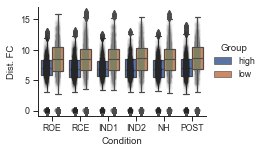

In [24]:
fig, ax = plt.subplots(figsize=(3, 2))

sb.boxplot(x="Condition", y="Distance", data=df[mask], hue="Group")
sb.stripplot(
    x="Condition",
    y="Distance",
    data=df[mask],
    hue="Group",
    dodge=True,
    legend=False,
    alpha=0.005,
    color="grey",
)

sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

ax.set_ylabel("Dist. FC")

sb.despine()


fig_name = f"FC_distance_btw_subjects_distribution_{n_windows}_windows"
#plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

high vs. low: Wilcoxon test (paired samples), P_val:0.000e+00 Stat=6.240e+07


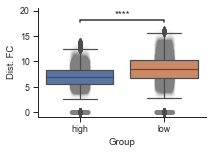

In [44]:
fig, ax = plt.subplots(figsize=(3, 2))

sb.boxplot(x="Group", y="Distance", data=df[mask])
sb.stripplot(
    x="Group",
    y="Distance",
    data=df[mask],
    #hue="Group",
    dodge=True,
    #legend=True,
    alpha=0.005,
    color="grey",
    zorder=-2
)

#sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

from statannotations.Annotator import Annotator

annotator = Annotator(
    ax,
    [("high", "low")],
    data=df[mask],
    x="Group",
    y="Distance",
    #hue="Group",
    #order=order,
    #hue_order=["high", "low"],
)
annotator.configure(test="Wilcoxon", text_format="star", loc="inside")
annotator.apply_and_annotate()


ax.set_ylabel("Dist. FC")

sb.despine()


fig_name = f"FC_distance_btw_subjects_group_distribution_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RCE_high vs. RCE_low: Wilcoxon test (paired samples), P_val:3.318e-159 Stat=1.769e+06
ROE_high vs. ROE_low: Wilcoxon test (paired samples), P_val:4.860e-164 Stat=1.742e+06
IND1_high vs. IND1_low: Wilcoxon test (paired samples), P_val:1.528e-162 Stat=1.750e+06
IND2_high vs. IND2_low: Wilcoxon test (paired samples), P_val:3.954e-163 Stat=1.747e+06
NH_high vs. NH_low: Wilcoxon test (paired samples), P_val:1.979e-180 Stat=1.651e+06
POST_high vs. POST_low: Wilcoxon test (paired samples), P_val:2.392e-163 Stat=1.745e+06


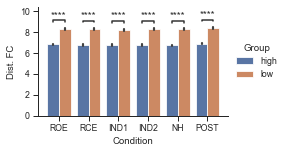

In [198]:
fig, ax = plt.subplots(figsize=(3.4, 2))

order = [("ROE"), ("RCE"), ("IND1"), ("IND2"), ("NH"), ("POST")]


# Crea un barplot delle distribuzioni
sb.barplot(x="Condition", y="Distance", data=df[mask], hue="Group")

# Titolo del grafico
# plt.title("Idiff distribuition")

var = order
pairs1 = [[(i, "high"), (i, "low")] for i in var]
# pairs2 = [[(i, "low"), (j, "low")] for i, j in combinations(["ROE", "RCE", "NH"], 2)]
pairs3 = [[(i, "high"), (j, "high")] for i, j in combinations(["ROE", "RCE", "NH"], 2)]

pairs = pairs1  # + pairs3

from statannotations.Annotator import Annotator

annotator = Annotator(
    ax,
    pairs,
    data=df[mask],
    x="Condition",
    y="Distance",
    hue="Group",
    order=order,
    hue_order=["high", "low"],
)
annotator.configure(test="Wilcoxon", text_format="star", loc="inside")
annotator.apply_and_annotate()

sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

ax.set_ylabel("Dist. FC")

sb.despine()


fig_name = f"FC_distance_btw_subjects_barplots_{n_windows}_windows"
plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")


plt.show()

In [224]:
mask_subj_ij = (df["Subject_i"] == "01") * (df["Subject_j"] == "02") 

df[mask]

,Group,Condition,Subject_i,Subject_j,Window_i,Window_j,Distance,Subject_ij
0,high,ROE,01,01,0,0,0.000000,"(01, 01)"
18,high,ROE,01,02,0,0,7.301901,"(01, 02)"
36,high,ROE,01,03,0,0,8.214360,"(01, 03)"
54,high,ROE,01,04,0,0,7.145456,"(01, 04)"
72,high,ROE,01,05,0,0,8.718184,"(01, 05)"
...,...,...,...,...,...,...,...,...
874727,low,POST,31,27,17,17,9.966125,"(31, 27)"
874745,low,POST,31,28,17,17,10.258021,"(31, 28)"
874763,low,POST,31,29,17,17,9.096250,"(31, 29)"
874781,low,POST,31,30,17,17,8.731976,"(31, 30)"


In [225]:
2 * 15 * 6 * 18 *15

48600

In [237]:
df[mask]

,Group,Condition,Subject_i,Subject_j,Window_i,Window_j,Distance,Subject_ij
0,high,ROE,01,01,0,0,0.000000,"(01, 01)"
18,high,ROE,01,02,0,0,7.301901,"(01, 02)"
36,high,ROE,01,03,0,0,8.214360,"(01, 03)"
54,high,ROE,01,04,0,0,7.145456,"(01, 04)"
72,high,ROE,01,05,0,0,8.718184,"(01, 05)"
...,...,...,...,...,...,...,...,...
874727,low,POST,31,27,17,17,9.966125,"(31, 27)"
874745,low,POST,31,28,17,17,10.258021,"(31, 28)"
874763,low,POST,31,29,17,17,9.096250,"(31, 29)"
874781,low,POST,31,30,17,17,8.731976,"(31, 30)"


In [233]:
# average over windows 
df_to_save = df[mask].groupby(by=["Group", "Condition", "Subject_ij"])["Distance"].mean().reset_index()


In [239]:
data_out_dir

'../data/functional_connectivity/'

In [238]:
df[mask].to_csv(f"{data_out_dir}FC_dst_btw_subjects.csv", index=False)

In [236]:
df_to_save

,Group,Condition,Subject_ij,Distance
0,high,IND1,"(01, 01)",0.000000
1,high,IND1,"(01, 02)",7.969017
2,high,IND1,"(01, 03)",6.938432
3,high,IND1,"(01, 04)",7.513150
4,high,IND1,"(01, 05)",9.525700
...,...,...,...,...
2695,low,ROE,"(31, 27)",10.559080
2696,low,ROE,"(31, 28)",10.179150
2697,low,ROE,"(31, 29)",9.122518
2698,low,ROE,"(31, 30)",9.060127


In [178]:
import pandas as pd

# Sample DataFrame
data = {
    'First_Column': ['A', 'B', 'A', 'C', 'B'],
    'Second_Column': ['X', 'Y', 'X', 'Y', 'Z'],
    'Third_Column': [10, 20, 30, 40, 50]
}

df = pd.DataFrame(data)

# Group by both First_Column and Second_Column
grouped = df.groupby(['First_Column', 'Second_Column'])

# Iterate through the groups and perform operations on them
for group_name, group_data in grouped:
    print(f"Group: {group_name}")
    print(group_data)
    # Perform operations on each group as needed


Group: ('A', 'X')
  First_Column Second_Column  Third_Column
0            A             X            10
2            A             X            30
Group: ('B', 'Y')
  First_Column Second_Column  Third_Column
1            B             Y            20
Group: ('B', 'Z')
  First_Column Second_Column  Third_Column
4            B             Z            50
Group: ('C', 'Y')
  First_Column Second_Column  Third_Column
3            C             Y            40


In [179]:
grouped.mean()

Third_Column
First_Column Second_Column              
A            X                      20.0
B            Y                      20.0
             Z                      50.0
C            Y                      40.0

In [77]:
mask_high = df["Group"] == "high"
mask_same_wdw = df["Window_i"] == df["Window_j"]
dmeanhigh = []
dstdhigh = []

for i, subject_i in enumerate(subjects_high):
    mask_i = df["Subject_i"] == subject_i
    # print(subject_i)

    for j, subject_j in enumerate(subjects_high):
        mask_j = df["Subject_j"] == subject_j
        # print(subject_j)

        mask = mask_i & mask_j
        mask1 = mask_i & mask_j & mask_high * mask_same_wdw

        dist_filtered_high = df[mask1]

        dmeanhigh.append(dist_filtered_high["Distance"].mean())
        dstdhigh.append(dist_filtered_high["Distance"].std())
        nhigh = len(dist_filtered_high)

In [78]:
mask_low = df["Group"] == "low"
dmeanlow = []
dstdlow = []

for i, subject_i in enumerate(subjects_low):
    mask_i = df["Subject_i"] == subject_i

    for j, subject_j in enumerate(subjects_low):
        mask_j = df["Subject_j"] == subject_j

        mask = mask_i & mask_j
        mask1 = mask_i & mask_j & mask_low * mask_same_wdw

        dist_filtered_low = df[mask1]

        dmeanlow.append(dist_filtered_low["Distance"].mean())
        dstdlow.append(dist_filtered_low["Distance"].std())
        nlow = len(dist_filtered_low)

In [79]:
print(min(dmeanhigh))
print(max(dmeanhigh))
print(min(dmeanlow))
print(max(dmeanlow))

0.0
9.937279641510273
0.0
13.677616723115314


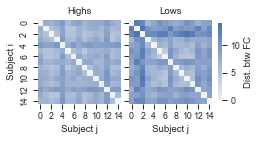

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2), sharex=False, sharey=True, layout="constrained")

ax1, ax2 = axs

im1 = sb.heatmap(
    np.reshape(dmeanhigh, (15, 15)),
    cmap=cmap,
    square=True,
    cbar=False,
    ax=ax1,
    #xticklabels=conditions_list,
    #yticklabels=conditions_list,
    cbar_kws={"shrink": 0.6},
    vmin=0,
    vmax=14
)

ax1.set_xlabel("Subject j")
ax1.set_ylabel("Subject i")

#########


ax2 = sb.heatmap(
    np.reshape(dmeanlow, (15, 15)),
    cmap=cmap,
    square=True,
    cbar=True,
    ax=ax2,
    #xticklabels=conditions_list,
    #yticklabels=conditions_list,
    cbar_kws={"shrink": 0.6, "label":"Dist. btw FC"},
    vmin=0,
    vmax=14
)

ax2.set_xlabel("Subject j")
#ax2.set_xticklabels(conditions_list, rotation=90, ha="center")
#ax2.set_yticklabels(conditions_list, rotation=0, va="center")

#fig.colorbar(
#    ax1.collections[0], ax=axs, shrink=0.5, fraction=0.25, label="FC corr. dist."
#)

ax1.set_title("Highs")
ax2.set_title("Lows")

title = "FC_DM_both"
# plt.suptitle(title)

fig_name = f"distance_matrices_between_FCs_avg_{n_windows}_windows"
#plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

plt.show()

In [81]:
df_high = pd.DataFrame(dmeanhigh) 
df_high.columns = ["distance"]
df_high["group"] = "high"
df_high

df_low = pd.DataFrame(dmeanlow) 
df_low.columns = ["distance"]
df_low["group"] = "low"
df_low

dist_df = pd.concat([df_high, df_low], ignore_index=True)
dist_df

,distance,group
0,0.000000,high
1,7.662357,high
2,7.099424,high
3,7.877639,high
4,9.599690,high
...,...,...
445,10.871964,low
446,9.897260,low
447,8.860275,low
448,8.535924,low


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

high vs. low: Wilcoxon test (paired samples), P_val:2.202e-13 Stat=4.610e+03


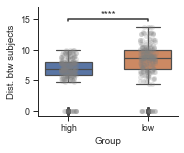

In [83]:
fig, ax = plt.subplots(figsize=(2.5, 2))

# Crea un barplot delle distribuzioni
sb.boxplot(data=dist_df, x="group", y="distance", width=0.6)
# sb.stripplot(x='Group', y='Data', data=df, dodge=True, color="k")

sb.stripplot(
    x="group",
    y="distance",
    data=dist_df,
    dodge=True,
    legend=False,
    alpha=0.2,
    color="grey",
)


from statannotations.Annotator import Annotator

annotator = Annotator(ax, pairs=[("high", "low")], data=dist_df, x="group", y="distance")
annotator.test = "Wilcoxon"
annotator.loc = "inside"
annotator.text_format = "star"
annotator.apply_and_annotate()

# Titolo del grafico
# plt.title("Idiff distribuition")
ax.set_ylabel("Dist. btw subjects")
ax.set_xlabel("Group")

#ax.set_yticks([])
sb.despine()

fig_name = f"FC_condition_idiff_distrib_barplots_grouped_{n_windows}_windows"
#plt.savefig(f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight")

plt.show()

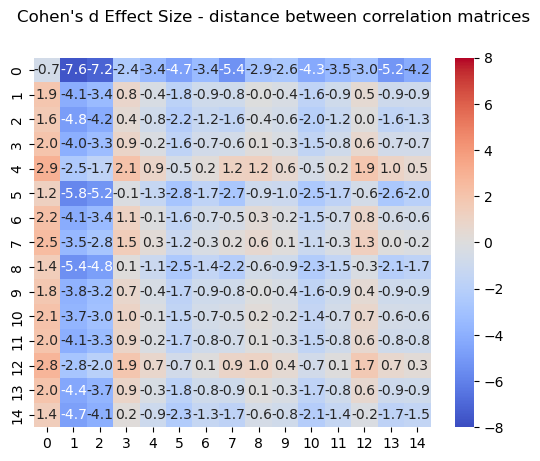

In [65]:
effect_size = np.zeros((15, 15))

for i in range(15):
    # print(i)
    mean_i = dmeanhigh[i]
    std_i = dstdhigh[i]
    # print(mean_i)
    for j in range(15):
        # print(j)
        mean_j = dmeanlow[j]
        std_j = dstdlow[j]
        # print(mean_j)

        difference = mean_i - mean_j
        pooled_std = np.sqrt(
            ((std_i**2 * (nhigh - 1)) + (std_j**2 * (nlow - 1)))
            / (nhigh + nlow - 2)
        )

        effect_size[i, j] = difference / pooled_std

title = "Cohen's d Effect Size - distance between correlation matrices"
plt.suptitle(title)

sb.heatmap(
    effect_size, cmap="coolwarm", annot=True, fmt=".1f", center=0.00, vmin=-8, vmax=8
)

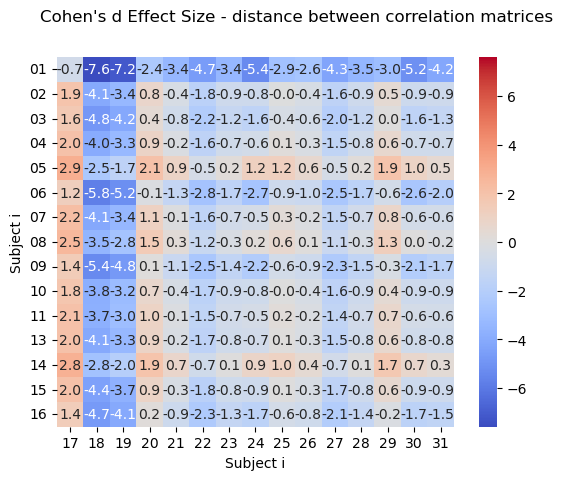

In [66]:
title = "Cohen's d Effect Size - distance between correlation matrices"
plt.suptitle(title)
sb.heatmap(
    effect_size, cmap="coolwarm", annot=True, fmt=".1f", center=0.0, vmin=-7.6, vmax=7.6
)
# vmin= -0.20, vmax= 0.20 ,

ax = plt.gca()
ax.set_xticklabels(subjects_low, rotation=0, ha="center")
ax.set_yticklabels(subjects_high, rotation=0, va="center")

# Regola i tick per centrare le etichette
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

plt.xlabel("Subject i", fontsize=10)
plt.ylabel("Subject i", fontsize=10)